In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [31]:
def plot_anomaly_ranges(file_path, buffer_points=10):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.sort_values('indo_time').reset_index(drop=True)

    anomaly_ranges = []
    check = 0
    for i in range(len(df)):
        if df.iloc[i]["pred_label"] == 1 and check == 0:
            start = df.iloc[i]["indo_time"]
            check = 1
        elif df.iloc[i]["pred_label"] == 0 and check == 1:
            end = df.iloc[i-1]["indo_time"]
            check = 0
            anomaly_ranges.append({"start" : start, "end" : end})

    if df['indo_time'].dtype == 'object':
        df['indo_time'] = pd.to_datetime(df['indo_time'])

    sns.set_style("whitegrid")

    n_anomalies = len(anomaly_ranges)
    fig, axes = plt.subplots(n_anomalies, 1, figsize=(12, 4*n_anomalies))

    if n_anomalies == 1:
        axes = [axes]

    for idx, (anomaly, ax) in enumerate(zip(anomaly_ranges, axes)):
        start_time = pd.to_datetime(anomaly['start'])
        end_time = pd.to_datetime(anomaly['end'])

        anomaly_mask = (df['indo_time'] >= start_time) & (df['indo_time'] <= end_time)
        anomaly_indices = df[anomaly_mask].index

        if len(anomaly_indices) == 0:
            ax.text(0.5, 0.5, f'No data found for anomaly {idx+1}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Anomaly {idx+1}: {start_time} to {end_time}')
            continue

        start_idx = max(0, anomaly_indices[0] - buffer_points)
        end_idx = min(len(df) - 1, anomaly_indices[-1] + buffer_points)

        plot_data = df.iloc[start_idx:end_idx+1].copy()

        plot_data['is_anomaly'] = ((plot_data['indo_time'] >= start_time) & 
                                   (plot_data['indo_time'] <= end_time))

        normal_mask = ~plot_data['is_anomaly']
        ax.plot(plot_data.loc[normal_mask, 'indo_time'], 
                plot_data.loc[normal_mask, 'speed'], 
                'o-', color='blue', markersize=1, alpha=0.6, label='Normal')

        anomaly_mask = plot_data['is_anomaly']
        ax.plot(plot_data.loc[anomaly_mask, 'indo_time'], 
                plot_data.loc[anomaly_mask, 'speed'], 
                'o-', color='red', markersize=1, alpha=0.8, label='Anomaly')

        ax.axvline(x=start_time, color='green', linestyle='--', alpha=0.7, label='Start')
        ax.axvline(x=end_time, color='orange', linestyle='--', alpha=0.7, label='End')

        ax.set_xlabel('Time')
        ax.set_ylabel('Speed')
        ax.set_title(f'Anomaly {idx+1}: {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
        ax.legend()

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [32]:
def load_and_preprocess(file_path):
    """Load and preprocess the data"""
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.sort_values('indo_time').reset_index(drop=True)
    
    if df['indo_time'].dtype == 'object':
        df['indo_time'] = pd.to_datetime(df['indo_time'])

    df['hour'] = df['indo_time'].dt.hour
    df['minute'] = df['indo_time'].dt.minute
    df['day_of_week'] = df['indo_time'].dt.dayofweek
    df['time_diff'] = df['indo_time'].diff().dt.total_seconds()
    
    return df

In [33]:
def basic_statistics(df):
    """Generate basic statistics for the dataset"""
    print("=== Basic Dataset Information ===")
    print(f"Total records: {len(df)}")
    print(f"Time range: {df['indo_time'].min()} to {df['indo_time'].max()}")
    print(f"Duration: {df['indo_time'].max() - df['indo_time'].min()}")
    print(f"\nAnomaly counts:")
    print(df['pred_label'].value_counts())
    print(f"Anomaly percentage: {(df['pred_label'].sum() / len(df)) * 100:.2f}%")
    
    print("\n=== Speed Statistics ===")
    print("Overall:")
    print(df['speed'].describe())
    
    print("\nNormal data:")
    print(df[df['pred_label'] == 0]['speed'].describe())
    
    print("\nAnomaly data:")
    print(df[df['pred_label'] == 1]['speed'].describe())

In [34]:
def plot_speed_distribution(df):
    """Plot speed distribution for normal vs anomaly data"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].hist(df['speed'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Overall Speed Distribution')
    axes[0, 0].set_xlabel('Speed')
    axes[0, 0].set_ylabel('Frequency')

    normal_speeds = df[df['pred_label'] == 0]['speed']
    anomaly_speeds = df[df['pred_label'] == 1]['speed']
    
    axes[0, 1].hist(normal_speeds, bins=50, alpha=0.5, label='Normal', color='blue')
    axes[0, 1].hist(anomaly_speeds, bins=50, alpha=0.5, label='Anomaly', color='red')
    axes[0, 1].set_title('Speed Distribution: Normal vs Anomaly')
    axes[0, 1].set_xlabel('Speed')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    data_to_plot = [normal_speeds, anomaly_speeds]
    axes[1, 0].boxplot(data_to_plot, labels=['Normal', 'Anomaly'])
    axes[1, 0].set_title('Speed Box Plot Comparison')
    axes[1, 0].set_ylabel('Speed')

    df_plot = pd.DataFrame({
        'Speed': df['speed'],
        'Type': df['pred_label'].map({0: 'Normal', 1: 'Anomaly'})
    })
    sns.violinplot(x='Type', y='Speed', data=df_plot, ax=axes[1, 1])
    axes[1, 1].set_title('Speed Violin Plot')
    
    plt.tight_layout()
    plt.show()

In [35]:
def plot_time_series_features(df):
    """Plot various time series features"""
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    normal_mask = df['pred_label'] == 0
    anomaly_mask = df['pred_label'] == 1
    
    axes[0, 0].scatter(df.loc[normal_mask, 'indo_time'], 
                      df.loc[normal_mask, 'speed'], 
                      c='blue', s=1, alpha=0.5, label='Normal')
    axes[0, 0].scatter(df.loc[anomaly_mask, 'indo_time'], 
                      df.loc[anomaly_mask, 'speed'], 
                      c='red', s=1, alpha=0.8, label='Anomaly')
    axes[0, 0].set_title('Speed Over Time')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Speed')
    axes[0, 0].legend()

    window_size = 60
    df['rolling_mean'] = df['speed'].rolling(window=window_size).mean()
    df['rolling_std'] = df['speed'].rolling(window=window_size).std()
    
    axes[0, 1].plot(df['indo_time'], df['rolling_mean'], label='Rolling Mean', alpha=0.7)
    axes[0, 1].fill_between(df['indo_time'], 
                           df['rolling_mean'] - 2*df['rolling_std'],
                           df['rolling_mean'] + 2*df['rolling_std'],
                           alpha=0.3, label='±2 STD')
    axes[0, 1].set_title('Rolling Statistics (1-minute window)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Speed')
    axes[0, 1].legend()
    
    df['speed_change'] = df['speed'].diff()
    axes[1, 0].plot(df['indo_time'], df['speed_change'], alpha=0.7)
    axes[1, 0].set_title('Speed Change (First Derivative)')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Speed Change')
    
    df['acceleration'] = df['speed_change'].diff()
    axes[1, 1].plot(df['indo_time'], df['acceleration'], alpha=0.7)
    axes[1, 1].set_title('Acceleration change (Second Derivative)')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Acceleration')
    
    hourly_stats = df.groupby('hour').agg({
        'speed': ['mean', 'std'],
        'pred_label': 'sum'
    })
    
    ax2 = axes[2, 0].twinx()
    axes[2, 0].bar(hourly_stats.index, hourly_stats[('pred_label', 'sum')], 
                   alpha=0.5, color='red', label='Anomaly Count')
    ax2.plot(hourly_stats.index, hourly_stats[('speed', 'mean')], 
             'b-o', label='Avg Speed')
    axes[2, 0].set_xlabel('Hour of Day')
    axes[2, 0].set_ylabel('Anomaly Count', color='red')
    ax2.set_ylabel('Average Speed', color='blue')
    axes[2, 0].set_title('Hourly Pattern Analysis')
    
    anomaly_ranges = []
    in_anomaly = False
    start_idx = 0
    
    for i, label in enumerate(df['pred_label']):
        if label == 1 and not in_anomaly:
            start_idx = i
            in_anomaly = True
        elif label == 0 and in_anomaly:
            duration = i - start_idx
            anomaly_ranges.append(duration)
            in_anomaly = False
    
    if anomaly_ranges:
        axes[2, 1].hist(anomaly_ranges, bins=30, edgecolor='black')
        axes[2, 1].set_title('Anomaly Duration Distribution')
        axes[2, 1].set_xlabel('Duration (seconds)')
        axes[2, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [36]:
def plot_frequency_analysis(df):
    """Perform frequency domain analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    n = len(df)
    yf = fft(df['speed'].values)
    xf = fftfreq(n, 1)[:n//2]
    
    axes[0, 0].plot(xf[1:], 2.0/n * np.abs(yf[1:n//2]))
    axes[0, 0].set_title('Frequency Spectrum (FFT)')
    axes[0, 0].set_xlabel('Frequency (Hz)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_xlim(0, 0.5)
    
    from scipy import signal
    frequencies, psd = signal.welch(df['speed'], fs=1, nperseg=256)
    axes[0, 1].semilogy(frequencies, psd)
    axes[0, 1].set_title('Power Spectral Density')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('PSD')
    
    frequencies, times, Sxx = signal.spectrogram(df['speed'], fs=1, nperseg=128)
    im = axes[1, 0].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_title('Spectrogram')
    plt.colorbar(im, ax=axes[1, 0], label='Power (dB)')
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(df['speed'].dropna(), lags=100, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()

In [37]:
def plot_anomaly_characteristics(df):
    """Analyze characteristics specific to anomalies"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    df['label_change'] = df['pred_label'].diff()
    anomaly_starts = df[df['label_change'] == 1]
    anomaly_ends = df[df['label_change'] == -1]
    
    axes[0, 0].hist(anomaly_starts['speed'], bins=30, alpha=0.5, 
                    label='Anomaly Start', color='red')
    axes[0, 0].hist(anomaly_ends['speed'], bins=30, alpha=0.5, 
                    label='Anomaly End', color='green')
    axes[0, 0].set_title('Speed at Anomaly Transitions')
    axes[0, 0].set_xlabel('Speed')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    axes[0, 1].hist(anomaly_starts['speed_change'].dropna(), bins=30, alpha=0.5, 
                    label='Anomaly Start', color='red')
    axes[0, 1].hist(anomaly_ends['speed_change'].dropna(), bins=30, alpha=0.5, 
                    label='Anomaly End', color='green')
    axes[0, 1].set_title('Speed Change at Anomaly Transitions')
    axes[0, 1].set_xlabel('Speed Change')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    anomaly_df = df[df['pred_label'] == 1]
    hourly_anomaly_speed = anomaly_df.groupby('hour')['speed'].agg(['mean', 'std', 'count'])
    
    axes[0, 2].bar(hourly_anomaly_speed.index, hourly_anomaly_speed['count'])
    ax2 = axes[0, 2].twinx()
    ax2.plot(hourly_anomaly_speed.index, hourly_anomaly_speed['mean'], 
             'r-o', label='Mean Speed')
    axes[0, 2].set_xlabel('Hour of Day')
    axes[0, 2].set_ylabel('Anomaly Count')
    ax2.set_ylabel('Mean Anomaly Speed', color='red')
    axes[0, 2].set_title('Anomaly Patterns by Hour')

    df['anomaly_group'] = (df['pred_label'] != df['pred_label'].shift()).cumsum()
    anomaly_groups = df[df['pred_label'] == 1].groupby('anomaly_group')
    
    group_sizes = anomaly_groups.size()
    group_speed_ranges = anomaly_groups['speed'].agg(['min', 'max', 'mean', 'std'])
    
    axes[1, 0].scatter(group_sizes, group_speed_ranges['max'] - group_speed_ranges['min'])
    axes[1, 0].set_xlabel('Anomaly Duration (seconds)')
    axes[1, 0].set_ylabel('Speed Range')
    axes[1, 0].set_title('Anomaly Duration vs Speed Range')

    normal_mean = df[df['pred_label'] == 0]['speed'].mean()
    normal_std = df[df['pred_label'] == 0]['speed'].std()
    df['z_score'] = (df['speed'] - normal_mean) / normal_std
    
    axes[1, 1].hist(df[df['pred_label'] == 1]['z_score'], bins=50, 
                    edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Anomaly Severity (Z-scores)')
    axes[1, 1].set_xlabel('Z-score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', label='Normal Mean')
    axes[1, 1].legend()

    anomaly_times = df[df['pred_label'] == 1]['indo_time']
    if len(anomaly_times) > 1:
        time_gaps = []
        prev_time = None
        for time in anomaly_times:
            if prev_time is not None:
                gap = (time - prev_time).total_seconds()
                if gap > 1:
                    time_gaps.append(gap)
            prev_time = time
        
        if time_gaps:
            axes[1, 2].hist(time_gaps, bins=50, edgecolor='black')
            axes[1, 2].set_title('Time Between Anomalies')
            axes[1, 2].set_xlabel('Time Gap (seconds)')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

In [38]:
def plot_statistical_tests(df):
    """Perform and visualize statistical tests"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    normal_speeds = df[df['pred_label'] == 0]['speed']
    anomaly_speeds = df[df['pred_label'] == 1]['speed']
    
    stats.probplot(normal_speeds, dist="norm", plot=axes[0, 0])
    axes[0, 0].set_title('Q-Q Plot: Normal Data')
    
    stats.probplot(anomaly_speeds, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot: Anomaly Data')

    normal_speeds.plot.kde(ax=axes[1, 0], label='Normal', color='blue')
    anomaly_speeds.plot.kde(ax=axes[1, 0], label='Anomaly', color='red')
    axes[1, 0].set_title('Kernel Density Estimation')
    axes[1, 0].set_xlabel('Speed')
    axes[1, 0].legend()

    axes[1, 1].axis('off')
    test_results = []

    if len(normal_speeds) < 5000:
        normal_shapiro = stats.shapiro(normal_speeds.sample(min(5000, len(normal_speeds))))
        anomaly_shapiro = stats.shapiro(anomaly_speeds.sample(min(5000, len(anomaly_speeds))))
        test_results.append(f"Shapiro-Wilk Test (Normality):")
        test_results.append(f"  Normal data: p-value = {normal_shapiro.pvalue:.4f}")
        test_results.append(f"  Anomaly data: p-value = {anomaly_shapiro.pvalue:.4f}")

    mw_stat, mw_pvalue = stats.mannwhitneyu(normal_speeds, anomaly_speeds)
    test_results.append(f"\nMann-Whitney U Test:")
    test_results.append(f"  Statistic = {mw_stat:.2f}")
    test_results.append(f"  p-value = {mw_pvalue:.4e}")

    ks_stat, ks_pvalue = stats.ks_2samp(normal_speeds, anomaly_speeds)
    test_results.append(f"\nKolmogorov-Smirnov Test:")
    test_results.append(f"  Statistic = {ks_stat:.4f}")
    test_results.append(f"  p-value = {ks_pvalue:.4e}")
    
    axes[1, 1].text(0.1, 0.9, '\n'.join(test_results), 
                    transform=axes[1, 1].transAxes, 
                    verticalalignment='top',
                    fontfamily='monospace')
    axes[1, 1].set_title('Statistical Test Results')
    
    plt.tight_layout()
    plt.show()

In [39]:
def create_summary_report(df):
    """Create a comprehensive summary report"""
    print("\n" + "="*60)
    print("COMPREHENSIVE ANOMALY DETECTION EDA SUMMARY")
    print("="*60)
    
    basic_statistics(df)
    
    print("\n=== Anomaly Characteristics ===")

    df['anomaly_group'] = (df['pred_label'] != df['pred_label'].shift()).cumsum()
    anomaly_segments = df[df['pred_label'] == 1].groupby('anomaly_group')
    
    if len(anomaly_segments) > 0:
        durations = anomaly_segments.size()
        print(f"Number of anomaly segments: {len(durations)}")
        print(f"Average anomaly duration: {durations.mean():.2f} seconds")
        print(f"Max anomaly duration: {durations.max()} seconds")
        print(f"Min anomaly duration: {durations.min()} seconds")

        anomaly_speeds = df[df['pred_label'] == 1]['speed']
        normal_speeds = df[df['pred_label'] == 0]['speed']
        
        print(f"\nSpeed difference (anomaly vs normal):")
        print(f"  Mean difference: {anomaly_speeds.mean() - normal_speeds.mean():.2f}")
        print(f"  Median difference: {anomaly_speeds.median() - normal_speeds.median():.2f}")

    print("\n=== Temporal Patterns ===")
    hourly_anomalies = df[df['pred_label'] == 1].groupby('hour').size()
    print(f"Most anomalies occur at hour: {hourly_anomalies.idxmax()}")
    print(f"Least anomalies occur at hour: {hourly_anomalies.idxmin()}")
    
    print("\n" + "="*60)

In [40]:
def run_comprehensive_eda(file_path):
    """Run all EDA functions on the dataset"""
    print(f"Loading data from: {file_path}")
    df = load_and_preprocess(file_path)

    create_summary_report(df)

    print("\nGenerating visualizations...")
    
    plot_speed_distribution(df)
    plot_time_series_features(df)
    plot_frequency_analysis(df)
    plot_anomaly_characteristics(df)
    plot_statistical_tests(df)
    plot_anomaly_ranges(file_path)
    
    return df

In [42]:
df = run_comprehensive_eda('..\Data\event_all.csv')

Loading data from: ..\Data\event_all.csv


ValueError: Inconsistent use of : in +071000, at position 96199. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [16]:
def plot_advanced_patterns(df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    from scipy.signal import find_peaks
    speed_diff = np.abs(df['speed'].diff())
    peaks, properties = find_peaks(speed_diff, height=np.percentile(speed_diff.dropna(), 95))
    
    axes[0, 0].plot(df['indo_time'], df['speed'], alpha=0.5)
    axes[0, 0].scatter(df.iloc[peaks]['indo_time'], df.iloc[peaks]['speed'], 
                      color='red', s=5, zorder=5, label='Changepoints')
    axes[0, 0].set_title('Changepoint Detection')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Speed')
    axes[0, 0].legend()

    speed = df['speed'].values
    acceleration = df['speed'].diff().values
    
    normal_mask = df['pred_label'] == 0
    anomaly_mask = df['pred_label'] == 1
    
    axes[0, 1].scatter(speed[normal_mask], acceleration[normal_mask], 
                      c='blue', s=1, alpha=0.3, label='Normal')
    axes[0, 1].scatter(speed[anomaly_mask], acceleration[anomaly_mask], 
                      c='red', s=1, alpha=0.5, label='Anomaly')
    axes[0, 1].set_title('Phase Space: Speed vs Acceleration')
    axes[0, 1].set_xlabel('Speed')
    axes[0, 1].set_ylabel('Acceleration')
    axes[0, 1].legend()

    window_sizes = [60, 300, 600]
    colors = ['blue', 'green', 'orange']
    
    for window, color in zip(window_sizes, colors):
        rolling_cv = df['speed'].rolling(window).std() / df['speed'].rolling(window).mean()
        axes[1, 0].plot(df['indo_time'], rolling_cv, alpha=0.7, 
                       label=f'{window}s window', color=color)
    
    axes[1, 0].set_title('Coefficient of Variation (Rolling Windows)')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('CV')
    axes[1, 0].legend()

    df['time_bin'] = pd.cut(df.index, bins=100)
    heatmap_data = df.groupby(['time_bin', pd.cut(df['speed'], bins=50)])['pred_label'].sum()
    heatmap_matrix = heatmap_data.unstack(fill_value=0)
    
    sns.heatmap(heatmap_matrix.T, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Anomaly Count'})
    axes[1, 1].set_title('Anomaly Density: Time vs Speed')
    axes[1, 1].set_xlabel('Time Bins')
    axes[1, 1].set_ylabel('Speed Bins')

    from sklearn.neighbors import LocalOutlierFactor

    features = df[['speed', 'speed_change', 'acceleration']].fillna(0)

    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outlier_scores = lof.fit_predict(features)
    outlier_factor = lof.negative_outlier_factor_
    
    scatter = axes[2, 0].scatter(df['indo_time'], df['speed'], 
                                c=outlier_factor, cmap='RdYlBu', s=1)
    axes[2, 0].set_title('Local Outlier Factor Scores')
    axes[2, 0].set_xlabel('Time')
    axes[2, 0].set_ylabel('Speed')
    plt.colorbar(scatter, ax=axes[2, 0], label='LOF Score')

    transitions = pd.crosstab(df['pred_label'], df['pred_label'].shift(-1))
    
    sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues', ax=axes[2, 1])
    axes[2, 1].set_title('State Transition Matrix')
    axes[2, 1].set_xlabel('Next State')
    axes[2, 1].set_ylabel('Current State')
    
    plt.tight_layout()
    plt.show()

In [17]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [18]:
def plot_feature_engineering_insights(df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    df['speed_ma_5'] = df['speed'].rolling(5).mean()
    df['speed_ma_30'] = df['speed'].rolling(30).mean()
    df['speed_std_30'] = df['speed'].rolling(30).std()
    df['speed_zscore'] = (df['speed'] - df['speed_ma_30']) / df['speed_std_30']
    df['speed_momentum'] = df['speed'] - df['speed'].shift(10)
    df['speed_rsi'] = calculate_rsi(df['speed'], 14)

    axes[0, 0].plot(df['indo_time'], df['speed'], alpha=0.3, label='Raw')
    axes[0, 0].plot(df['indo_time'], df['speed_ma_5'], label='MA-5')
    axes[0, 0].plot(df['indo_time'], df['speed_ma_30'], label='MA-30')

    anomaly_mask = df['pred_label'] == 1
    axes[0, 0].scatter(df.loc[anomaly_mask, 'indo_time'], 
                      df.loc[anomaly_mask, 'speed'], 
                      c='red', s=1, alpha=0.5, label='Anomaly')
    
    axes[0, 0].set_title('Moving Averages and Anomalies')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Speed')
    axes[0, 0].legend()

    normal_mask = df['pred_label'] == 0
    anomaly_mask = df['pred_label'] == 1
    
    axes[0, 1].scatter(df.loc[normal_mask, 'indo_time'], 
                      df.loc[normal_mask, 'speed_zscore'], 
                      c='blue', s=1, alpha=0.3, label='Normal')
    axes[0, 1].scatter(df.loc[anomaly_mask, 'indo_time'], 
                      df.loc[anomaly_mask, 'speed_zscore'], 
                      c='red', s=1, alpha=0.5, label='Anomaly')
    axes[0, 1].axhline(y=3, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(y=-3, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Z-score Analysis')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Z-score')
    axes[0, 1].legend()

    feature_cols = ['speed', 'speed_change', 'acceleration', 'speed_ma_5', 
                   'speed_ma_30', 'speed_std_30', 'speed_momentum']
    correlation_matrix = df[feature_cols].corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=axes[1, 0])
    axes[1, 0].set_title('Feature Correlation Matrix')

    axes[1, 1].plot(df['indo_time'], df['speed_rsi'])
    axes[1, 1].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
    axes[1, 1].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')

    axes[1, 1].scatter(df.loc[anomaly_mask, 'indo_time'], 
                      df.loc[anomaly_mask, 'speed_rsi'], 
                      c='red', s=5, alpha=0.5, label='Anomaly')
    
    axes[1, 1].set_title('RSI Indicator and Anomalies')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('RSI')
    axes[1, 1].legend()
    
    from sklearn.ensemble import RandomForestClassifier

    feature_cols_ml = ['speed', 'speed_change', 'acceleration', 'speed_ma_5', 
                      'speed_ma_30', 'speed_std_30', 'speed_zscore', 
                      'speed_momentum', 'hour', 'minute']
    
    X = df[feature_cols_ml].fillna(0)
    y = df['pred_label']
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importance = pd.DataFrame({
        'feature': feature_cols_ml,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    axes[2, 0].barh(feature_importance['feature'], feature_importance['importance'])
    axes[2, 0].set_xlabel('Importance')
    axes[2, 0].set_title('Feature Importance for Anomaly Detection')

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    axes[2, 1].scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
                      c='blue', s=1, alpha=0.3, label='Normal')
    axes[2, 1].scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], 
                      c='red', s=1, alpha=0.5, label='Anomaly')
    axes[2, 1].set_title(f'PCA Visualization (explained var: {pca.explained_variance_ratio_.sum():.2%})')
    axes[2, 1].set_xlabel('PC1')
    axes[2, 1].set_ylabel('PC2')
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return df

In [19]:
def plot_anomaly_context_analysis(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    window = 60
    pre_anomaly_speeds = []
    post_anomaly_speeds = []
    
    anomaly_starts = df[df['pred_label'].diff() == 1].index
    
    for idx in anomaly_starts:
        if idx > window and idx < len(df) - window:
            pre_anomaly_speeds.extend(df.loc[idx-window:idx-1, 'speed'].values)
            post_anomaly_speeds.extend(df.loc[idx:idx+window, 'speed'].values)
    
    axes[0, 0].boxplot([pre_anomaly_speeds, post_anomaly_speeds], 
                       labels=['Pre-Anomaly', 'Post-Anomaly'])
    axes[0, 0].set_title('Speed Distribution: Before vs After Anomaly')
    axes[0, 0].set_ylabel('Speed')

    anomaly_times = df[df['pred_label'] == 1]['indo_time']
    time_diffs = anomaly_times.diff().dt.total_seconds().dropna()
    
    axes[0, 1].hist(time_diffs[time_diffs < 3600], bins=50, edgecolor='black')
    axes[0, 1].set_title('Time Between Consecutive Anomalies (<1 hour)')
    axes[0, 1].set_xlabel('Seconds')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_yscale('log')

    time_resolution = 60
    df['time_bin'] = (df.index // time_resolution)
    anomaly_pattern = df.groupby('time_bin')['pred_label'].max()

    n_cols = 60
    n_rows = len(anomaly_pattern) // n_cols + 1
    pattern_matrix = np.zeros((n_rows, n_cols))
    
    for i, val in enumerate(anomaly_pattern.values):
        row = i // n_cols
        col = i % n_cols
        if row < n_rows:
            pattern_matrix[row, col] = val
    
    axes[1, 0].imshow(pattern_matrix, cmap='RdBu_r', aspect='auto')
    axes[1, 0].set_title('Anomaly Pattern Matrix (1-min bins)')
    axes[1, 0].set_xlabel('Minute in Hour')
    axes[1, 0].set_ylabel('Hour Blocks')

    anomaly_segments = []
    current_segment = []
    
    for i, (label, speed) in enumerate(zip(df['pred_label'], df['speed'])):
        if label == 1:
            current_segment.append(speed)
        elif current_segment:
            if len(current_segment) > 10:
                anomaly_segments.append(current_segment)
            current_segment = []

    if anomaly_segments:
        max_len = max(len(seg) for seg in anomaly_segments)

        normalized_segments = []
        for seg in anomaly_segments[:20]:
            x = np.linspace(0, 1, len(seg))
            axes[1, 1].plot(x, seg, alpha=0.3, color='red')
        
        axes[1, 1].set_title('Speed Profiles During Anomalies')
        axes[1, 1].set_xlabel('Normalized Time')
        axes[1, 1].set_ylabel('Speed')
    
    plt.tight_layout()
    plt.show()

In [20]:
def create_interactive_dashboard(df):
    fig = plt.figure(figsize=(20, 12))

    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, :])
    normal_mask = df['pred_label'] == 0
    anomaly_mask = df['pred_label'] == 1
    
    ax1.scatter(df.loc[normal_mask, 'indo_time'], 
               df.loc[normal_mask, 'speed'], 
               c='blue', s=0.5, alpha=0.5, label='Normal')
    ax1.scatter(df.loc[anomaly_mask, 'indo_time'], 
               df.loc[anomaly_mask, 'speed'], 
               c='red', s=0.5, alpha=0.8, label='Anomaly')
    ax1.set_title('Speed Time Series with Anomalies', fontsize=14)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Speed')
    ax1.legend()

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(df[normal_mask]['speed'], bins=50, alpha=0.5, 
             label='Normal', color='blue', density=True)
    ax2.hist(df[anomaly_mask]['speed'], bins=50, alpha=0.5, 
             label='Anomaly', color='red', density=True)
    ax2.set_title('Speed Distribution')
    ax2.set_xlabel('Speed')
    ax2.set_ylabel('Density')
    ax2.legend()

    ax3 = fig.add_subplot(gs[1, 1])
    hourly_data = df.groupby('hour').agg({
        'pred_label': ['sum', 'count']
    })
    hourly_data['anomaly_pct'] = (hourly_data[('pred_label', 'sum')] / 
                                  hourly_data[('pred_label', 'count')] * 100)
    
    ax3.bar(hourly_data.index, hourly_data['anomaly_pct'])
    ax3.set_title('Anomaly Percentage by Hour')
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('Anomaly %')

    ax4 = fig.add_subplot(gs[1, 2])
    ax4.axis('off')
    
    stats_text = f"""
    Dataset Summary:
    ----------------
    Total Records: {len(df):,}
    Anomalies: {df['pred_label'].sum():,} ({df['pred_label'].mean()*100:.1f}%)
    
    Speed Statistics:
    Normal: μ={df[normal_mask]['speed'].mean():.1f}, σ={df[normal_mask]['speed'].std():.1f}
    Anomaly: μ={df[anomaly_mask]['speed'].mean():.1f}, σ={df[anomaly_mask]['speed'].std():.1f}
    
    Time Range:
    {df['indo_time'].min()} to 
    {df['indo_time'].max()}
    """
    
    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, 
             verticalalignment='top', fontfamily='monospace')

    ax5 = fig.add_subplot(gs[1, 3])
    anomaly_durations = []
    in_anomaly = False
    duration = 0
    
    for label in df['pred_label']:
        if label == 1:
            duration += 1
            in_anomaly = True
        elif in_anomaly:
            anomaly_durations.append(duration)
            duration = 0
            in_anomaly = False
    
    if anomaly_durations:
        ax5.hist(anomaly_durations, bins=30, edgecolor='black')
        ax5.set_title('Anomaly Duration Distribution')
        ax5.set_xlabel('Duration (seconds)')
        ax5.set_ylabel('Count')
        ax5.set_yscale('log')

    ax6 = fig.add_subplot(gs[2, 0])
    speed_change = df['speed'].diff()
    ax6.hist(speed_change[normal_mask], bins=50, alpha=0.5, 
             label='Normal', color='blue', density=True)
    ax6.hist(speed_change[anomaly_mask], bins=50, alpha=0.5, 
             label='Anomaly', color='red', density=True)
    ax6.set_title('Speed Change Distribution')
    ax6.set_xlabel('Speed Change')
    ax6.set_ylabel('Density')
    ax6.legend()

    ax7 = fig.add_subplot(gs[2, 1])
    from statsmodels.tsa.stattools import acf
    
    normal_acf = acf(df[normal_mask]['speed'].dropna(), nlags=50)
    anomaly_acf = acf(df[anomaly_mask]['speed'].dropna(), nlags=50)
    
    ax7.plot(normal_acf, label='Normal', color='blue')
    ax7.plot(anomaly_acf, label='Anomaly', color='red')
    ax7.set_title('Autocorrelation Comparison')
    ax7.set_xlabel('Lag')
    ax7.set_ylabel('ACF')
    ax7.legend()

    ax8 = fig.add_subplot(gs[2, 2:])
    ax8.axis('off')
    
    recommendations = """
    Recommendations for Anomaly Detection:
    --------------------------------------
    1. Consider using rolling statistics (mean, std) as features
    2. Speed change and acceleration show different patterns for anomalies
    3. Time-of-day appears to influence anomaly occurrence
    4. Anomalies tend to cluster in time - consider sequence models
    5. Multiple anomaly types may exist based on speed ranges
    6. Consider ensemble methods combining statistical and ML approaches
    """
    
    ax8.text(0.1, 0.9, recommendations, transform=ax8.transAxes, 
             verticalalignment='top', fontfamily='monospace')
    
    plt.suptitle('Anomaly Detection Dashboard', fontsize=16)
    plt.tight_layout()
    plt.show()

In [21]:
def detect_anomaly_types(df):
    anomaly_df = df[df['pred_label'] == 1].copy()

    normal_mean = df[df['pred_label'] == 0]['speed'].mean()
    normal_std = df[df['pred_label'] == 0]['speed'].std()
    
    anomaly_df['type'] = 'other'

    anomaly_df.loc[anomaly_df['speed'] > normal_mean + 2*normal_std, 'type'] = 'high_speed'

    anomaly_df.loc[anomaly_df['speed'] < normal_mean - 2*normal_std, 'type'] = 'low_speed'

    anomaly_df.loc[np.abs(anomaly_df['speed_change']) > anomaly_df['speed_change'].quantile(0.95), 'type'] = 'sudden_change'
    
    return anomaly_df

In [22]:
def run_advanced_eda(file_path):
    df = load_and_preprocess(file_path)

    df['speed_change'] = df['speed'].diff()
    df['acceleration'] = df['speed_change'].diff()
    
    print("Running advanced pattern analysis...")
    plot_advanced_patterns(df)
    
    print("Analyzing engineered features...")
    df = plot_feature_engineering_insights(df)
    
    print("Performing context analysis...")
    plot_anomaly_context_analysis(df)
    
    print("Creating interactive dashboard...")
    create_interactive_dashboard(df)

    anomaly_types = detect_anomaly_types(df)
    print("\nAnomaly Type Distribution:")
    print(anomaly_types['type'].value_counts())
    
    return df, anomaly_types

Running advanced pattern analysis...


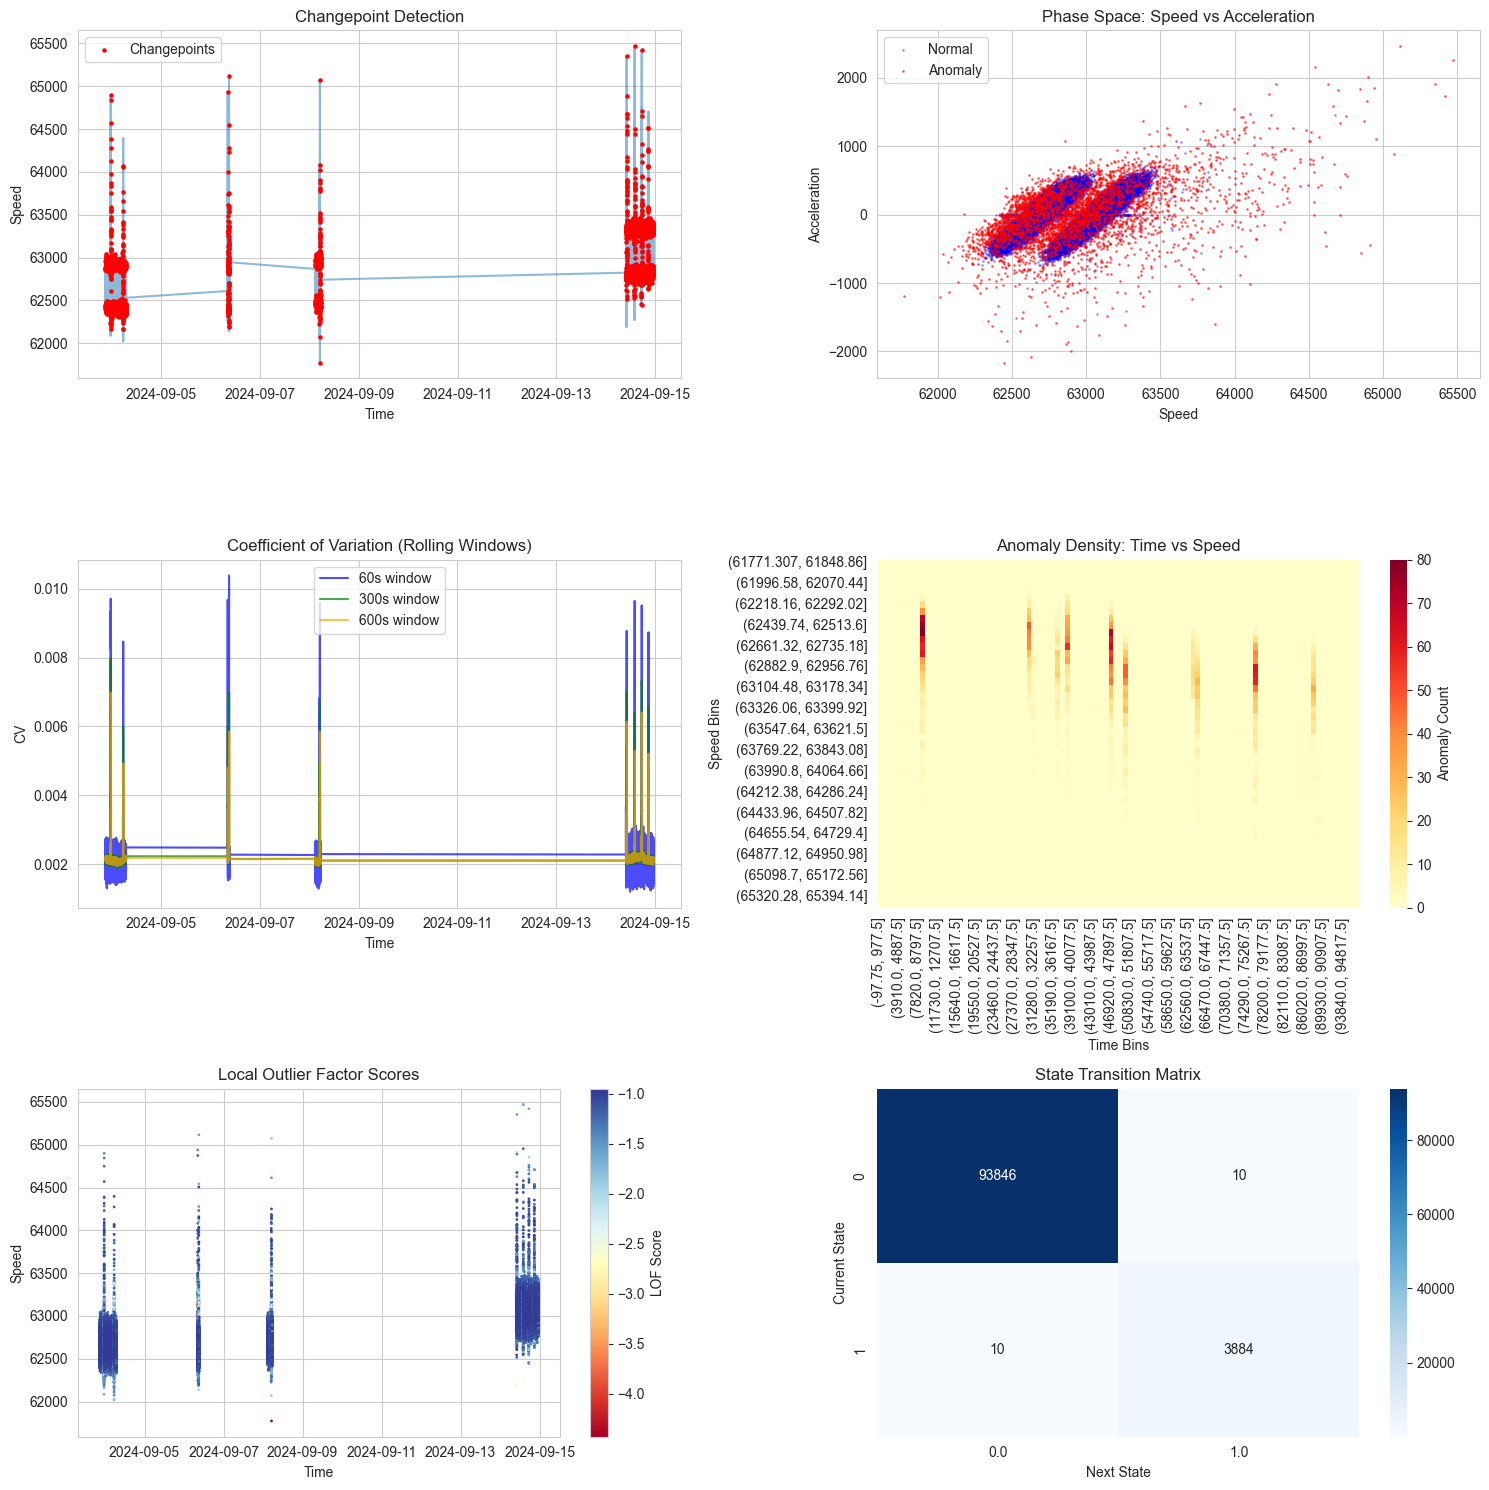

Analyzing engineered features...


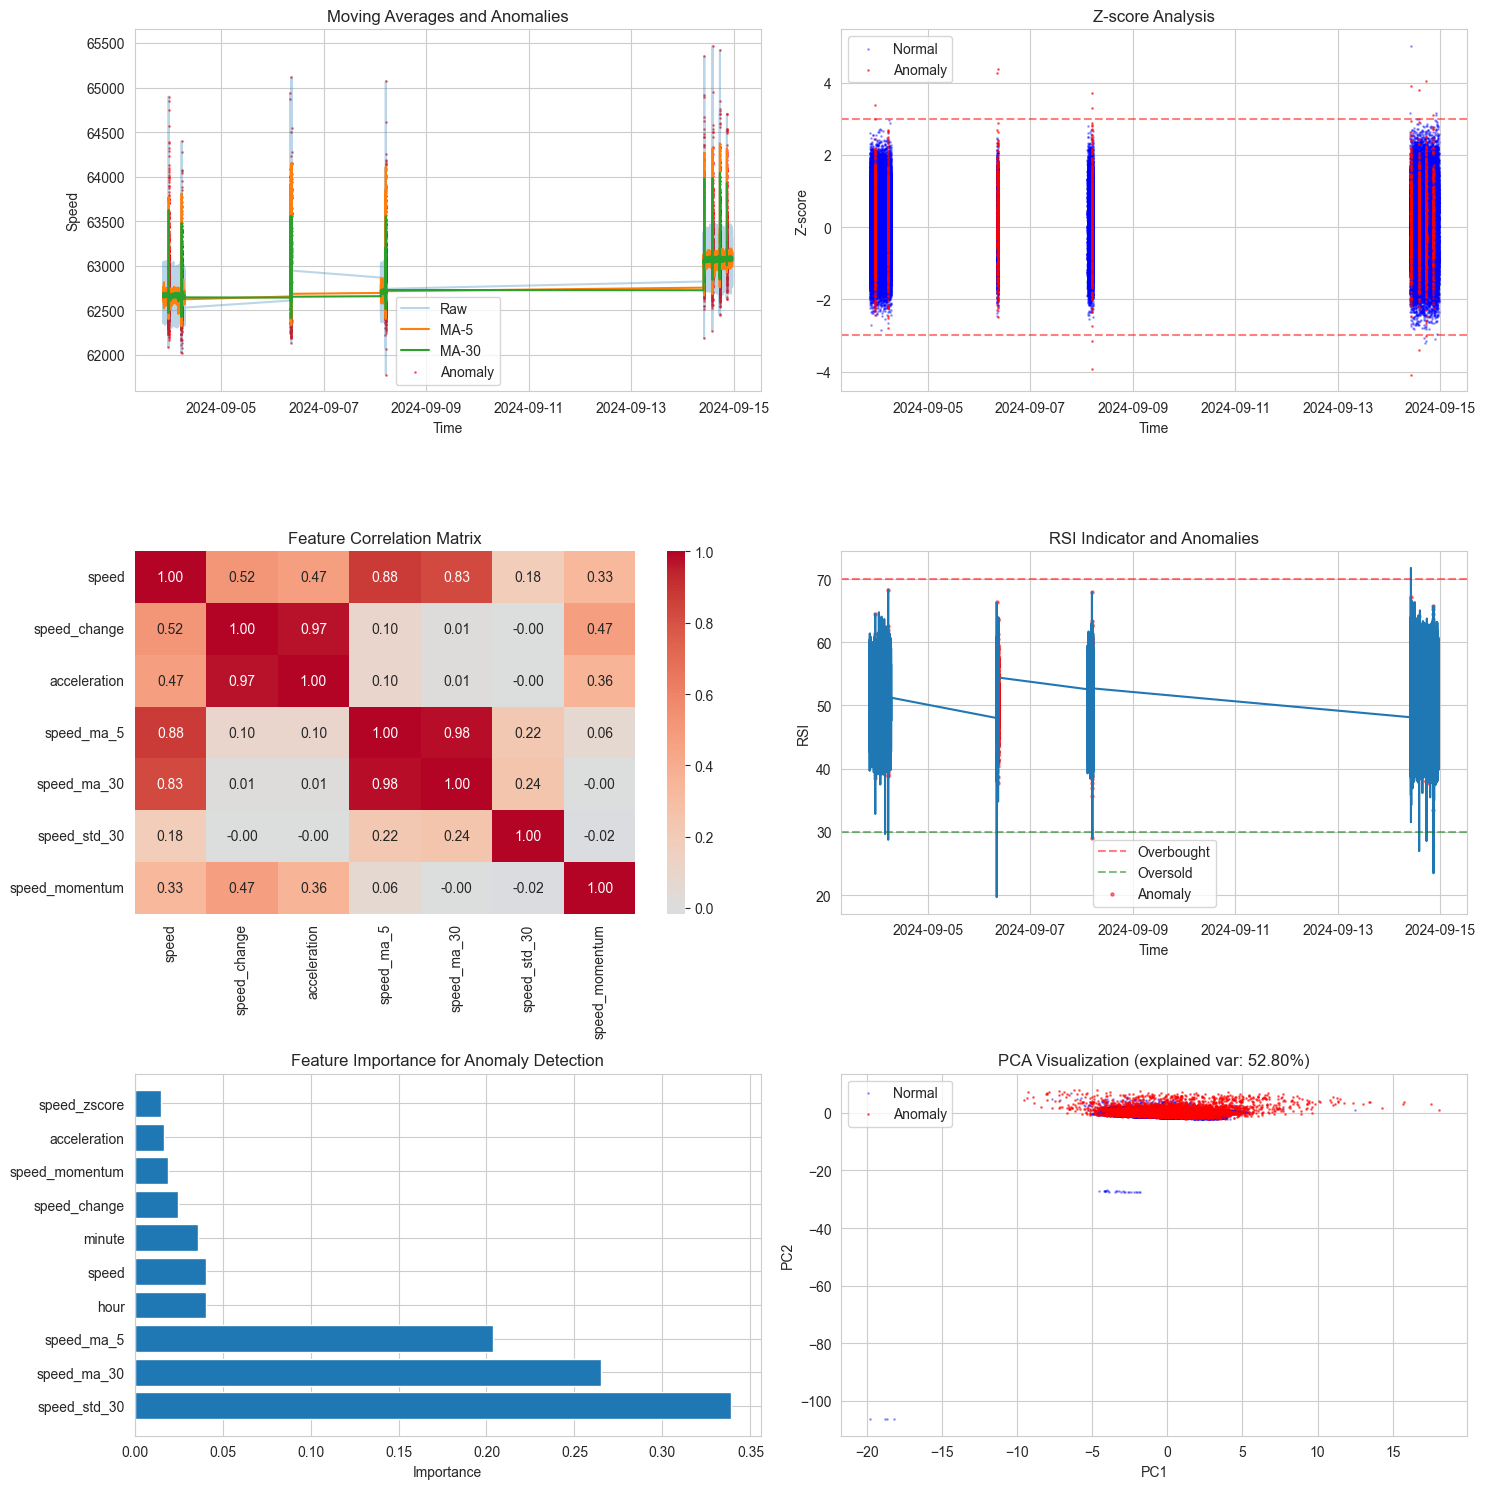

Performing context analysis...


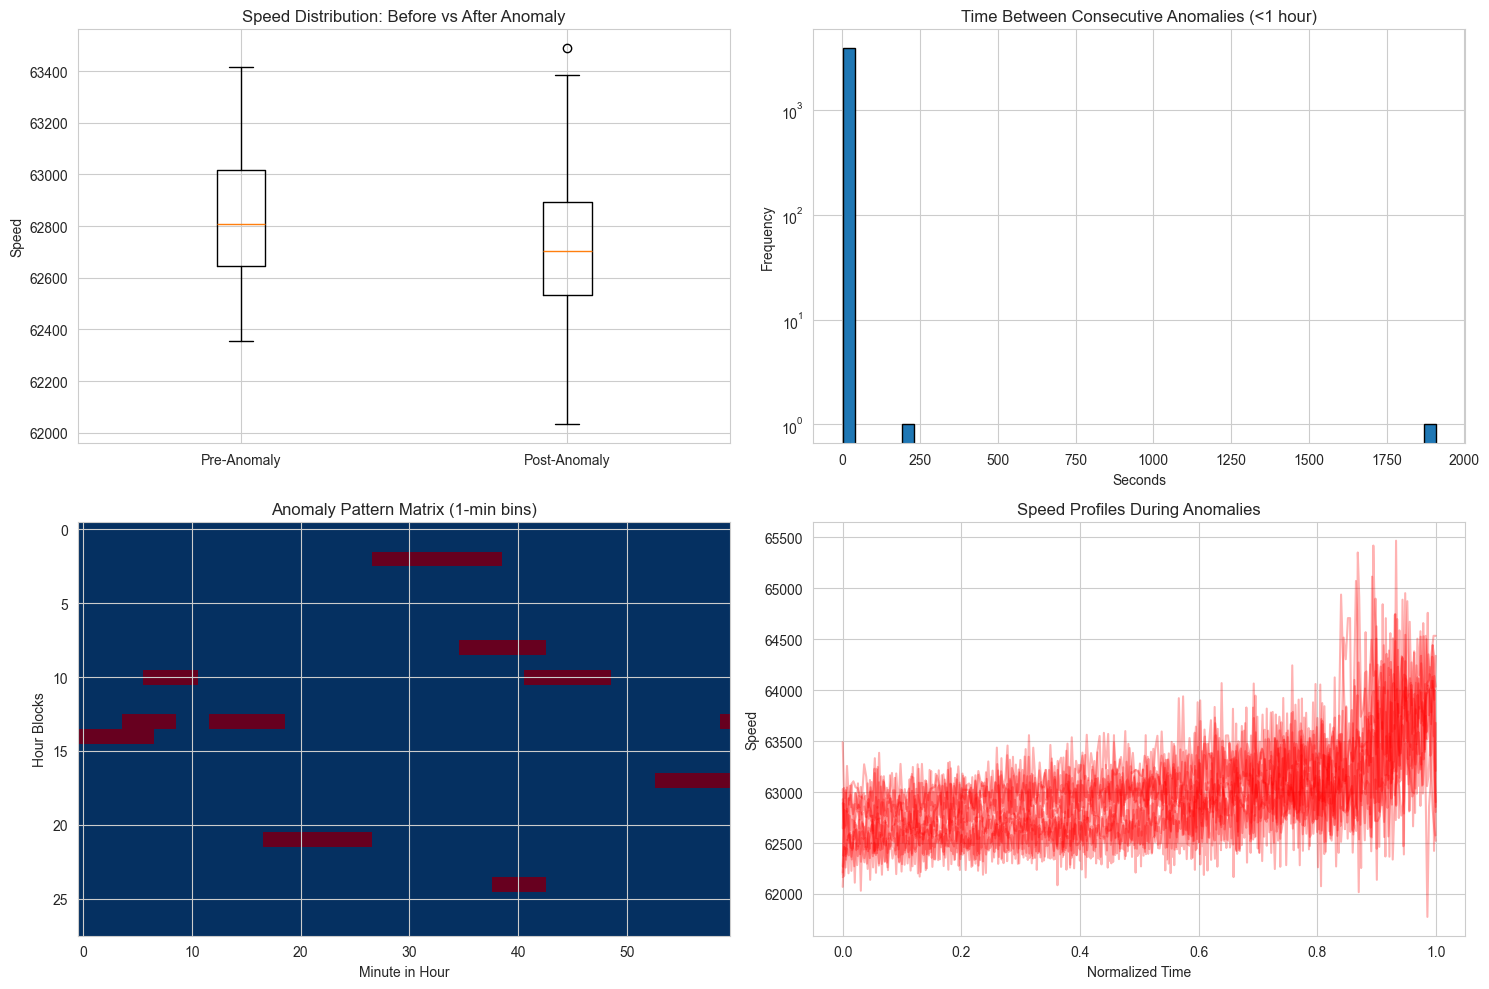

Creating interactive dashboard...


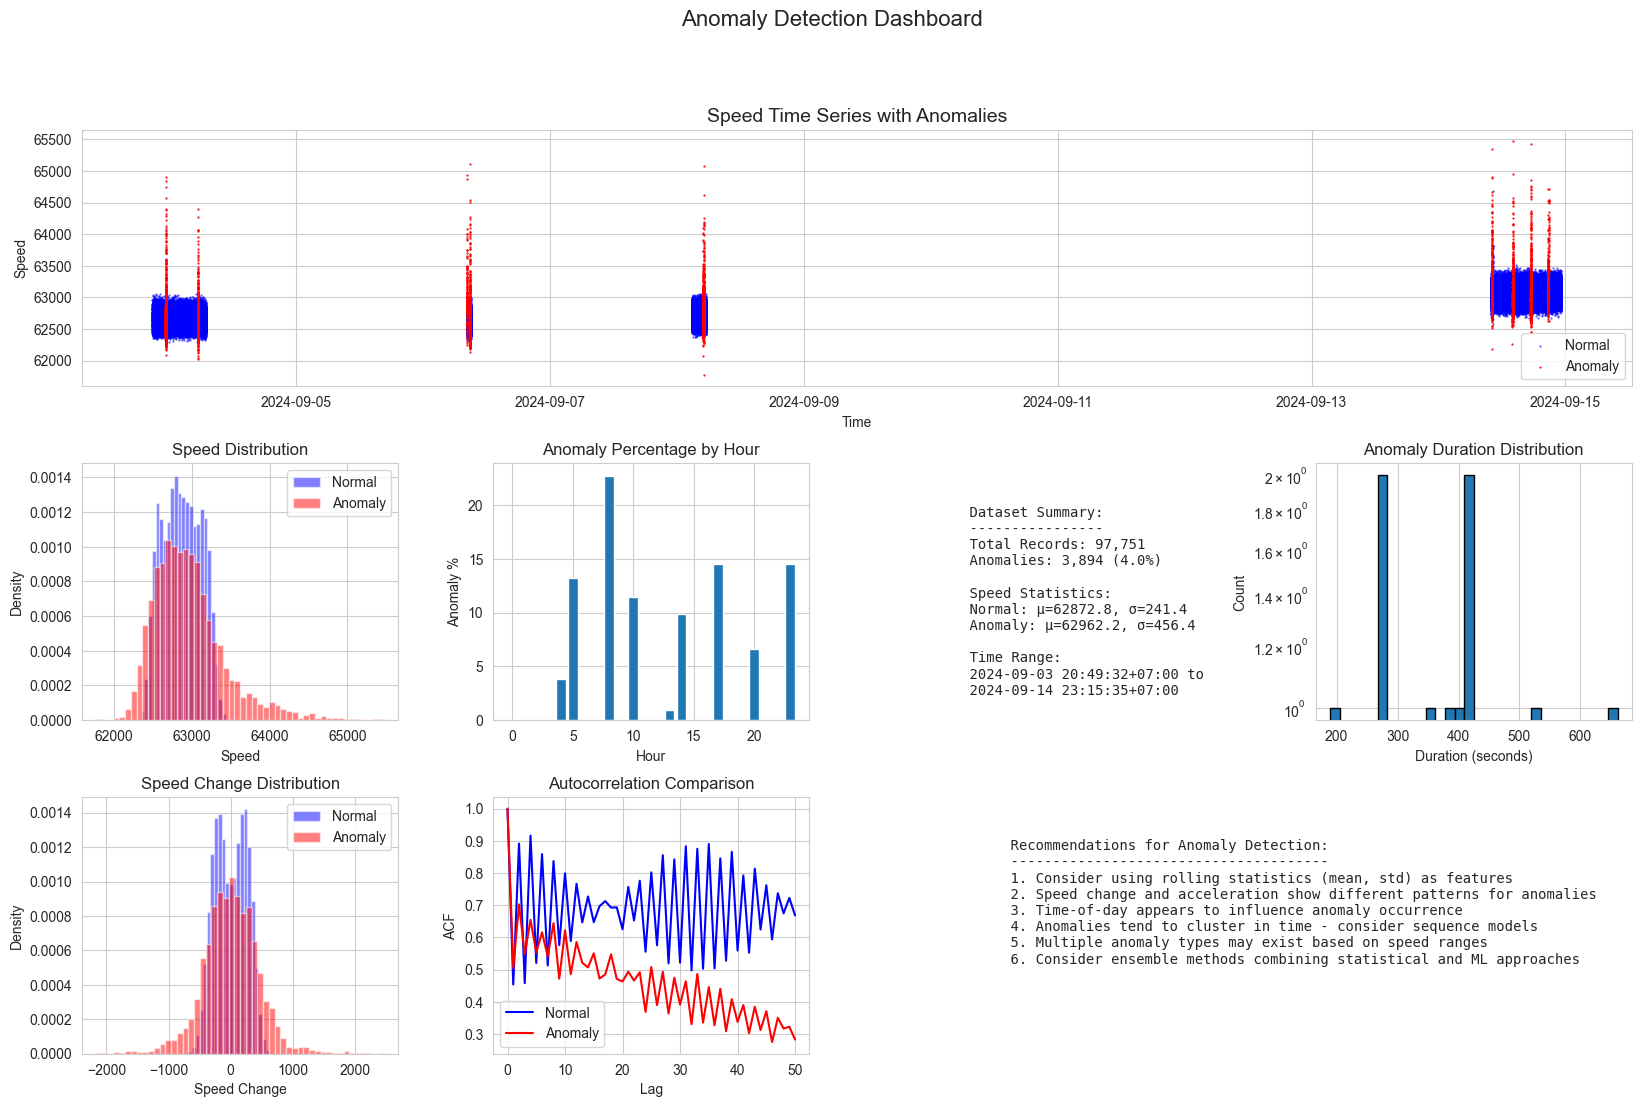


Anomaly Type Distribution:
type
other            2859
high_speed        440
sudden_change     408
low_speed         187
Name: count, dtype: int64


In [26]:
df, anomaly_types = run_advanced_eda("Data\AGC_Data.csv")

In [ ]:
def comprehensive_eda_plots(df, speed_col='speed', timestamp_col='indo_time', save_prefix='eda'):
    """
    Create comprehensive exploratory plots for unlabeled speed data.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")

    if timestamp_col in df.columns:
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    
    print("Creating exploratory plots...")
    
    # 1. DISTRIBUTION ANALYSIS
    fig = plt.figure(figsize=(20, 15))
    
    # 1.1 Speed Distribution
    plt.subplot(3, 3, 1)
    plt.hist(df[speed_col], bins=100, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(df[speed_col].mean(), color='red', linestyle='--', label=f'Mean: {df[speed_col].mean():.0f}')
    plt.axvline(df[speed_col].median(), color='green', linestyle='--', label=f'Median: {df[speed_col].median():.0f}')
    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.title('Speed Distribution')
    plt.legend()
    
    # 1.2 Log-transformed Distribution
    plt.subplot(3, 3, 2)
    log_speed = np.log1p(df[speed_col])
    plt.hist(log_speed, bins=100, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Log(Speed + 1)')
    plt.ylabel('Frequency')
    plt.title('Log-transformed Speed Distribution')
    
    # 1.3 Q-Q Plot for Normality
    plt.subplot(3, 3, 3)
    stats.probplot(df[speed_col], dist="norm", plot=plt)
    plt.title('Q-Q Plot (Normal Distribution)')
    
    # 2. TIME SERIES ANALYSIS
    # 2.1 Speed over Time
    plt.subplot(3, 3, 4)
    plt.plot(df[timestamp_col], df[speed_col], alpha=0.6, linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.title('Speed Time Series')
    plt.xticks(rotation=45)
    
    # 2.2 Rolling Statistics
    plt.subplot(3, 3, 5)
    window = min(1000, len(df) // 10)
    rolling_mean = df[speed_col].rolling(window=window, center=True).mean()
    rolling_std = df[speed_col].rolling(window=window, center=True).std()
    
    plt.plot(df[timestamp_col], rolling_mean, label=f'Rolling Mean (w={window})', color='red')
    plt.fill_between(df[timestamp_col], 
                     rolling_mean - 2*rolling_std, 
                     rolling_mean + 2*rolling_std, 
                     alpha=0.2, color='red', label='±2 STD')
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.title('Rolling Statistics')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 2.3 Speed Change Distribution
    plt.subplot(3, 3, 6)
    speed_changes = df[speed_col].diff().dropna()
    plt.hist(speed_changes, bins=100, alpha=0.7, color='purple', edgecolor='black')
    plt.xlabel('Speed Change')
    plt.ylabel('Frequency')
    plt.title('Distribution of Speed Changes')
    
    # 3. PATTERN ANALYSIS
    # 3.1 Autocorrelation
    plt.subplot(3, 3, 7)
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(df[speed_col].iloc[:min(5000, len(df))])
    plt.title('Autocorrelation of Speed')
    plt.xlabel('Lag')
    
    # 3.2 Hourly Patterns (if timestamp available)
    plt.subplot(3, 3, 8)
    if timestamp_col in df.columns:
        df['hour'] = df[timestamp_col].dt.hour
        hourly_stats = df.groupby('hour')[speed_col].agg(['mean', 'std'])
        
        plt.errorbar(hourly_stats.index, hourly_stats['mean'], 
                    yerr=hourly_stats['std'], fmt='o-', capsize=5)
        plt.xlabel('Hour of Day')
        plt.ylabel('Speed')
        plt.title('Hourly Speed Patterns')
        plt.xticks(range(0, 24, 2))
    
    # 3.3 Speed vs Speed Change
    plt.subplot(3, 3, 9)
    plt.scatter(df[speed_col].iloc[:-1], speed_changes, alpha=0.3, s=1)
    plt.xlabel('Speed')
    plt.ylabel('Speed Change')
    plt.title('Speed vs Speed Change')
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_distribution_analysis.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 4. OUTLIER DETECTION PLOTS
    fig = plt.figure(figsize=(20, 12))
    
    # 4.1 Box Plot
    plt.subplot(2, 3, 1)
    plt.boxplot(df[speed_col], vert=True)
    plt.ylabel('Speed')
    plt.title('Speed Box Plot')
    
    # 4.2 IQR-based Outliers
    plt.subplot(2, 3, 2)
    Q1 = df[speed_col].quantile(0.25)
    Q3 = df[speed_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (df[speed_col] < lower_bound) | (df[speed_col] > upper_bound)
    plt.scatter(range(len(df)), df[speed_col], c=outliers, cmap='coolwarm', s=1, alpha=0.5)
    plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axhline(y=upper_bound, color='red', linestyle='--', label='Upper Bound')
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.title(f'IQR-based Outliers ({outliers.sum()} detected)')
    plt.legend()
    
    # 4.3 Z-Score based Outliers
    plt.subplot(2, 3, 3)
    z_scores = np.abs(stats.zscore(df[speed_col]))
    z_threshold = 3
    z_outliers = z_scores > z_threshold
    
    plt.scatter(range(len(df)), df[speed_col], c=z_outliers, cmap='coolwarm', s=1, alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.title(f'Z-Score Outliers (|z| > {z_threshold}, {z_outliers.sum()} detected)')
    
    # 4.4 Rolling Z-Score
    plt.subplot(2, 3, 4)
    window = 1000
    rolling_mean = df[speed_col].rolling(window=window).mean()
    rolling_std = df[speed_col].rolling(window=window).std()
    rolling_z = (df[speed_col] - rolling_mean) / rolling_std
    
    plt.plot(rolling_z.dropna(), alpha=0.7, linewidth=0.5)
    plt.axhline(y=3, color='red', linestyle='--', label='±3σ')
    plt.axhline(y=-3, color='red', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Rolling Z-Score')
    plt.title(f'Rolling Z-Score (window={window})')
    plt.legend()
    
    # 4.5 Local Outlier Factor visualization
    plt.subplot(2, 3, 5)
    # Use recent window for LOF
    sample_size = min(5000, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_data = df.iloc[sample_indices]
    
    # Create features for LOF
    features = pd.DataFrame({
        'speed': sample_data[speed_col],
        'speed_diff': sample_data[speed_col].diff().fillna(0),
        'speed_rolling_std': sample_data[speed_col].rolling(10).std().fillna(0)
    })
    
    from sklearn.neighbors import LocalOutlierFactor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outlier_labels = lof.fit_predict(features)
    outlier_scores = lof.negative_outlier_factor_
    
    plt.scatter(range(len(sample_data)), sample_data[speed_col], 
                c=outlier_scores, cmap='coolwarm', s=10, alpha=0.6)
    plt.colorbar(label='LOF Score')
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.title('Local Outlier Factor Scores')
    
    # 4.6 Isolation Forest Score
    plt.subplot(2, 3, 6)
    from sklearn.ensemble import IsolationForest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_predictions = iso_forest.fit_predict(features)
    iso_scores = iso_forest.score_samples(features)
    
    plt.scatter(range(len(sample_data)), sample_data[speed_col], 
                c=iso_scores, cmap='coolwarm', s=10, alpha=0.6)
    plt.colorbar(label='Isolation Score')
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.title('Isolation Forest Anomaly Scores')
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_outlier_analysis.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 5. STATISTICAL ANALYSIS
    fig = plt.figure(figsize=(20, 12))
    
    # 5.1 Empirical CDF
    plt.subplot(2, 3, 1)
    sorted_speeds = np.sort(df[speed_col])
    p = np.arange(len(sorted_speeds)) / (len(sorted_speeds) - 1)
    plt.plot(sorted_speeds, p)
    plt.xlabel('Speed')
    plt.ylabel('Cumulative Probability')
    plt.title('Empirical CDF of Speed')
    plt.grid(True, alpha=0.3)
    
    # 5.2 Kernel Density Estimation
    plt.subplot(2, 3, 2)
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(df[speed_col].dropna())
    x_range = np.linspace(df[speed_col].min(), df[speed_col].max(), 1000)
    plt.plot(x_range, kde(x_range))
    plt.fill_between(x_range, kde(x_range), alpha=0.3)
    plt.xlabel('Speed')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation')
    
    # 5.3 Speed Percentiles
    plt.subplot(2, 3, 3)
    percentiles = np.arange(0, 101, 1)
    speed_percentiles = np.percentile(df[speed_col], percentiles)
    plt.plot(percentiles, speed_percentiles)
    plt.xlabel('Percentile')
    plt.ylabel('Speed')
    plt.title('Speed Percentiles')
    plt.grid(True, alpha=0.3)
    
    # 5.4 Moving Average Convergence
    plt.subplot(2, 3, 4)
    ma_short = df[speed_col].rolling(window=50).mean()
    ma_long = df[speed_col].rolling(window=500).mean()
    macd = ma_short - ma_long
    
    plt.plot(macd.dropna(), alpha=0.7, label='MACD')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('MACD')
    plt.title('Moving Average Convergence Divergence')
    plt.legend()
    
    # 5.5 Speed Volatility
    plt.subplot(2, 3, 5)
    volatility_window = 100
    volatility = df[speed_col].rolling(window=volatility_window).std()
    plt.plot(volatility, alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Standard Deviation')
    plt.title(f'Speed Volatility (window={volatility_window})')
    
    # 5.6 Return Distribution (% changes)
    plt.subplot(2, 3, 6)
    returns = df[speed_col].pct_change().dropna()
    plt.hist(returns, bins=100, alpha=0.7, density=True, color='green', edgecolor='black')
    
    # Fit normal distribution
    mu, sigma = returns.mean(), returns.std()
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal fit')
    plt.xlabel('Speed % Change')
    plt.ylabel('Density')
    plt.title('Distribution of Speed Returns')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_statistical_analysis.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 6. CLUSTERING AND PATTERN DISCOVERY
    fig = plt.figure(figsize=(20, 12))
    
    # Create multi-dimensional features
    print("Creating features for pattern discovery...")
    pattern_features = pd.DataFrame({
        'speed': df[speed_col],
        'speed_diff': df[speed_col].diff().fillna(0),
        'speed_diff2': df[speed_col].diff().diff().fillna(0),
        'speed_ma_10': df[speed_col].rolling(10).mean().fillna(df[speed_col]),
        'speed_std_10': df[speed_col].rolling(10).std().fillna(0),
        'speed_ma_50': df[speed_col].rolling(50).mean().fillna(df[speed_col]),
        'speed_std_50': df[speed_col].rolling(50).std().fillna(0)
    })
    
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(pattern_features.dropna())
    
    # 6.1 PCA visualization
    plt.subplot(2, 3, 1)
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features_scaled)
    
    plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.5, s=1)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
    plt.title('PCA of Speed Features')
    
    # 6.2 DBSCAN Clustering
    plt.subplot(2, 3, 2)
    # Use subset for DBSCAN
    subset_size = min(5000, len(features_scaled))
    subset_indices = np.random.choice(len(features_scaled), subset_size, replace=False)
    subset_features = features_scaled[subset_indices]
    
    dbscan = DBSCAN(eps=0.5, min_samples=50)
    clusters = dbscan.fit_predict(subset_features)
    
    plt.scatter(pca_features[subset_indices, 0], pca_features[subset_indices, 1], 
                c=clusters, cmap='viridis', s=10, alpha=0.6)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'DBSCAN Clustering ({len(np.unique(clusters))} clusters)')
    plt.colorbar(label='Cluster')
    
    # 6.3 Speed State Transitions
    plt.subplot(2, 3, 3)
    # Discretize speed into states
    speed_states = pd.qcut(df[speed_col], q=10, labels=False)
    transition_matrix = np.zeros((10, 10))
    
    for i in range(len(speed_states)-1):
        current_state = speed_states.iloc[i]
        next_state = speed_states.iloc[i+1]
        transition_matrix[current_state, next_state] += 1
    
    # Normalize
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    
    sns.heatmap(transition_matrix, cmap='YlOrRd', cbar_kws={'label': 'Transition Probability'})
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.title('Speed State Transition Matrix')
    
    # 6.4 Recurrence Plot
    plt.subplot(2, 3, 4)
    # Use small subset for recurrence plot
    rp_size = min(500, len(df))
    rp_data = df[speed_col].iloc[:rp_size].values
    
    # Create distance matrix
    distance_matrix = np.abs(rp_data[:, np.newaxis] - rp_data[np.newaxis, :])
    recurrence_matrix = distance_matrix < np.std(rp_data) * 0.1
    
    plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
    plt.xlabel('Time Index')
    plt.ylabel('Time Index')
    plt.title('Recurrence Plot')
    
    # 6.5 Phase Space Plot
    plt.subplot(2, 3, 5)
    lag = 10
    plt.scatter(df[speed_col].iloc[:-lag], df[speed_col].iloc[lag:], 
                alpha=0.3, s=1)
    plt.xlabel(f'Speed(t)')
    plt.ylabel(f'Speed(t+{lag})')
    plt.title(f'Phase Space Plot (lag={lag})')
    
    # 6.6 Spectral Analysis
    plt.subplot(2, 3, 6)
    from scipy.fft import fft, fftfreq
    
    # Remove trend
    detrended = df[speed_col] - df[speed_col].rolling(1000, center=True).mean().fillna(df[speed_col].mean())
    
    # Compute FFT
    fft_values = fft(detrended.dropna().values)
    frequencies = fftfreq(len(detrended.dropna()), 1)  # Assuming 1 second sampling
    
    # Plot power spectrum
    power = np.abs(fft_values)**2
    positive_freq_idxs = frequencies > 0
    
    plt.loglog(frequencies[positive_freq_idxs], power[positive_freq_idxs])
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('Power Spectral Density')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}_pattern_discovery.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 7. SUMMARY STATISTICS REPORT
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\nBasic Statistics:")
    print(f"  Total samples: {len(df):,}")
    print(f"  Speed range: {df[speed_col].min():.2f} - {df[speed_col].max():.2f}")
    print(f"  Mean speed: {df[speed_col].mean():.2f}")
    print(f"  Median speed: {df[speed_col].median():.2f}")
    print(f"  Std deviation: {df[speed_col].std():.2f}")
    print(f"  Skewness: {stats.skew(df[speed_col]):.3f}")
    print(f"  Kurtosis: {stats.kurtosis(df[speed_col]):.3f}")
    
    print(f"\nOutlier Detection Summary:")
    print(f"  IQR outliers: {outliers.sum()} ({outliers.sum()/len(df)*100:.2f}%)")
    print(f"  Z-score outliers (|z|>3): {z_outliers.sum()} ({z_outliers.sum()/len(df)*100:.2f}%)")
    
    print(f"\nTemporal Patterns:")
    if timestamp_col in df.columns:
        time_span = df[timestamp_col].max() - df[timestamp_col].min()
        print(f"  Time span: {time_span}")
        print(f"  Sampling rate: ~{len(df)/time_span.total_seconds():.2f} Hz")
    
    print(f"\nSpeed Change Analysis:")
    print(f"  Max absolute change: {speed_changes.abs().max():.2f}")
    print(f"  Mean absolute change: {speed_changes.abs().mean():.2f}")
    print(f"  Change volatility: {speed_changes.std():.2f}")
    
    # Save summary statistics
    summary_stats = {
        'basic_stats': df[speed_col].describe().to_dict(),
        'outlier_counts': {
            'iqr_outliers': int(outliers.sum()),
            'z_score_outliers': int(z_outliers.sum())
        },
        'distribution_metrics': {
            'skewness': float(stats.skew(df[speed_col])),
            'kurtosis': float(stats.kurtosis(df[speed_col]))
        }
    }
    
    import json
    with open(f'{save_prefix}_summary_stats.json', 'w') as f:
        json.dump(summary_stats, f, indent=2)
    
    print(f"\nPlots saved with prefix: {save_prefix}")
    print(f"Summary statistics saved to: {save_prefix}_summary_stats.json")
    
    return summary_stats


# Additional specialized plots for speed data
def create_anomaly_candidate_plots(df, speed_col='speed', timestamp_col='indo_time', save_prefix='anomaly_candidates'):
    """
    Create plots specifically focused on identifying potential anomalies.
    """
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Extreme Value Analysis
    plt.subplot(2, 2, 1)
    
    # Fit Generalized Extreme Value distribution
    from scipy.stats import genextreme
    params = genextreme.fit(df[speed_col])
    
    x = np.linspace(df[speed_col].min(), df[speed_col].max(), 1000)
    plt.hist(df[speed_col], bins=100, density=True, alpha=0.7, label='Data')
    plt.plot(x, genextreme.pdf(x, *params), 'r-', label='GEV fit')
    
    # Mark extreme values
    threshold_low = genextreme.ppf(0.001, *params)
    threshold_high = genextreme.ppf(0.999, *params)
    plt.axvline(threshold_low, color='red', linestyle='--', label=f'0.1% threshold')
    plt.axvline(threshold_high, color='red', linestyle='--', label=f'99.9% threshold')
    
    plt.xlabel('Speed')
    plt.ylabel('Density')
    plt.title('Extreme Value Analysis')
    plt.legend()
    
    # 2. Anomaly Score Heatmap
    plt.subplot(2, 2, 2)
    
    # Calculate multiple anomaly scores
    window = 1000
    
    # Z-score
    rolling_mean = df[speed_col].rolling(window).mean()
    rolling_std = df[speed_col].rolling(window).std()
    z_scores = np.abs((df[speed_col] - rolling_mean) / rolling_std)
    
    # MAD score
    rolling_median = df[speed_col].rolling(window).median()
    rolling_mad = df[speed_col].rolling(window).apply(lambda x: np.median(np.abs(x - np.median(x))))
    mad_scores = np.abs((df[speed_col] - rolling_median) / rolling_mad)
    
    # Sudden change score
    change_scores = np.abs(df[speed_col].diff()) / df[speed_col].rolling(window).std()
    
    # Combine scores
    scores_df = pd.DataFrame({
        'Z-Score': z_scores,
        'MAD Score': mad_scores,
        'Change Score': change_scores
    }).dropna()
    
    # Plot heatmap of top anomalous regions
    top_anomalies = scores_df.sum(axis=1).nlargest(1000)
    anomaly_regions = scores_df.loc[top_anomalies.index]
    
    sns.heatmap(anomaly_regions.T, cmap='YlOrRd', cbar_kws={'label': 'Anomaly Score'})
    plt.xlabel('Sample Index')
    plt.ylabel('Score Type')
    plt.title('Multi-Metric Anomaly Scores (Top 1000)')
    
    # 3. Contextual Anomalies
    plt.subplot(2, 2, 3)
    
    # Speed vs time of day anomalies
    if timestamp_col in df.columns:
        df['hour'] = pd.to_datetime(df[timestamp_col]).dt.hour
        
        # Calculate hourly statistics
        hourly_stats = df.groupby('hour')[speed_col].agg(['mean', 'std', 'count'])
        
        # Find contextual anomalies
        contextual_scores = []
        for idx, row in df.iterrows():
            hour = row['hour']
            if hourly_stats.loc[hour, 'count'] > 30:  # Enough samples
                z_score = abs(row[speed_col] - hourly_stats.loc[hour, 'mean']) / hourly_stats.loc[hour, 'std']
                contextual_scores.append(z_score)
            else:
                contextual_scores.append(0)
        
        df['contextual_anomaly_score'] = contextual_scores
        
        # Plot
        scatter = plt.scatter(df['hour'], df[speed_col], 
                            c=df['contextual_anomaly_score'], 
                            cmap='YlOrRd', s=1, alpha=0.5)
        plt.colorbar(scatter, label='Contextual Anomaly Score')
        
        # Add hourly means
        plt.plot(hourly_stats.index, hourly_stats['mean'], 'b-', linewidth=2, label='Hourly Mean')
        
        plt.xlabel('Hour of Day')
        plt.ylabel('Speed')
        plt.title('Contextual Anomalies by Hour')
        plt.legend()
    
    # 4. Collective Anomalies
    plt.subplot(2, 2, 4)
    
    # Identify sustained anomalous periods
    anomaly_threshold = 3  # z-score threshold
    is_anomalous = z_scores > anomaly_threshold
    
    # Find consecutive anomalies
    anomaly_groups = []
    current_group = []
    
    for i, is_anom in enumerate(is_anomalous):
        if is_anom:
            current_group.append(i)
        else:
            if len(current_group) > 10:  # Minimum length for collective anomaly
                anomaly_groups.append(current_group)
            current_group = []
    
    # Plot
    plt.plot(df[speed_col].values, alpha=0.5, linewidth=0.5)
    
    # Highlight collective anomalies
    for group in anomaly_groups[:10]:  # Show top 10
        plt.axvspan(group[0], group[-1], alpha=0.3, color='red')
    
    plt.xlabel('Index')
    plt.ylabel('Speed')
    plt.title(f'Collective Anomalies (Found {len(anomaly_groups)} groups)')
    
    plt.tight_layout()
    plt.savefig(f'{save_prefix}.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"\nAnomaly candidate plots saved as: {save_prefix}.png")
    
    # Return anomaly summary
    anomaly_summary = {
        'extreme_values': {
            'below_0.1_percentile': int((df[speed_col] < threshold_low).sum()),
            'above_99.9_percentile': int((df[speed_col] > threshold_high).sum())
        },
        'high_anomaly_scores': {
            'z_score_above_3': int((z_scores > 3).sum()),
            'mad_score_above_3': int((mad_scores > 3).sum())
        },
        'collective_anomalies': {
            'number_of_groups': len(anomaly_groups),
            'total_anomalous_points': sum(len(g) for g in anomaly_groups)
        }
    }
    
    return anomaly_summary


# Usage example
if __name__ == "__main__":
    # Load your unlabeled data
    df = pd.read_csv('Data/input_data.csv')
    df = df.rename(columns={'A2:MCPGSpeed': 'speed', 'Time_stamp': 'indo_time'})
    
    # Run comprehensive EDA
    summary_stats = comprehensive_eda_plots(df, speed_col='speed', timestamp_col='indo_time', save_prefix='eda')
    
    # Create anomaly-focused plots
    anomaly_summary = create_anomaly_candidate_plots(df, speed_col='speed', timestamp_col='indo_time', 
                                                     save_prefix='anomaly_candidates')

Creating exploratory plots...
Creating features for pattern discovery...

EXPLORATORY DATA ANALYSIS SUMMARY

Basic Statistics:
  Total samples: 34,599
  Speed range: 20434.90 - 23919.40
  Mean speed: 23031.65
  Median speed: 23102.60
  Std deviation: 340.95
  Skewness: -4.024
  Kurtosis: 15.875

Outlier Detection Summary:
  IQR outliers: 7164 (20.71%)
  Z-score outliers (|z|>3): 1547 (4.47%)

Temporal Patterns:
  Time span: 0 days 09:37:21
  Sampling rate: ~1.00 Hz

Speed Change Analysis:
  Max absolute change: 1920.70
  Mean absolute change: 6.34
  Change volatility: 23.28

Plots saved with prefix: eda
Summary statistics saved to: eda_summary_stats.json

Anomaly candidate plots saved as: anomaly_candidates.png
